In [153]:
import os

import pandas as pd
import deepchem as dc

import pandas as pd
import pylab as p

from tqdm import tqdm
import json
import time
import csv
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, adjusted_rand_score, rand_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy import stats
from scipy.spatial import distance
from scipy.stats import pearsonr
import statsmodels.api as sm


In [67]:
def plot_scatter_with_regression(x, y, confidence_interval=0.95):
    # 使用 seaborn 绘制散点图和拟合线
    sns.scatterplot(x=x, y=y, label='Data')

    # 使用 scipy 进行线性回归
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # 绘制拟合线
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x'
    plt.plot(x, intercept + slope * x, color='red', label=line)

    # 计算置信区间
    ci = stats.linregress(x, y).interval(confidence_interval)

    # 绘制置信区间
    plt.fill_between(x, (intercept + slope * x - std_err),
                     (intercept + slope * x + std_err), color='gray', alpha=0.2,
                     label=f'{confidence_interval * 100}% Confidence Interval')

    # 添加标签和图例
    plt.title('Scatter Plot with Regression Line and Confidence Interval')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # 显示图形
    plt.show()

In [2]:
#Get Indexes and abstracts from Pubmed

with open("./PubMed/pubmed_CTD_0.json", 'r', encoding='utf') as f:
    jsons = json.load(f)

json_data = [x for x in jsons if x['abstract_text'] and x['year']]

with open("./PubMed/pubmed_CTD_1.json", 'r', encoding='utf') as f:
    jsons = json.load(f)

json_data += [x for x in jsons if x['abstract_text'] and x['year']]

with open("./PubMed/pubmed_CTD_2.json", 'r', encoding='utf') as f:
    jsons = json.load(f)

json_data += [x for x in jsons if x['abstract_text'] and x['year']]

pmids = []
years = []
abstract_texts = []

for js in json_data:
    pmids.append(str(js['pmid']))
    years.append(js['year'])
    abstract_texts.append(js['abstract_text'])

pmid_df = pd.DataFrame({
    'pmid': pmids,
    'year': years,
    'abstract_text': abstract_texts
})

pmid_df.to_csv("./Pmid_e.csv", index=False)

pmid_df

,pmid,year,abstract_text
0,706,1976,Thirteen out of 18 young out-patients with sim...
1,1803,1976,Mice were given a drug per os and 2 h later we...
2,1959,1976,"In a double-blind trial lasting 2 weeks, a new..."
3,2004,1976,Eight patients had cardiac manifestations that...
4,2127,1976,Beta-Adrenergic stimulation with isoproterenol...
...,...,...,...
9284,3418400,1988,Two episodes of massive bleeding from a suture...
9285,3419247,1988,The anti-amnestic action of nicergoline was st...
9286,3420160,1988,Protective influence of verapamil upon ouabain...
9287,3420309,1988,An unusual case of acute muscular atrophy in a...


In [3]:
# Read the Chemical Disease Database
chem_dis = pd.read_csv("./CTD/CTD_chemicals_diseases.csv", comment='#', low_memory=False)
chem_dis["DiseaseID"] = chem_dis["DiseaseID"].str.extract(r'(D\d+)')

# Get the Subset of Chemicals with validated iupac names
Chem_id = pd.read_csv("./Identifier/Chem_id.csv")
chem_dis = chem_dis[chem_dis['ChemicalName'].isin(Chem_id['iupac'])]

# Subset Pubmed Ids with validated iupac name
pubMed_ids = []
for s in chem_dis['PubMedIDs']:
    t = str(s).split('|')
    pubMed_ids += t
pubMed_ids = list(set(pubMed_ids))

# Get the intersection of pubmed ids
k_l = [x for x in pmid_df['pmid'] if x in pubMed_ids]
pmid_e_df = pmid_df[pmid_df['pmid'].isin(k_l)]

chems = []
diseases = []
pmids = []
abstracts = []

for i, row in chem_dis.iterrows():
    for t in str(row['PubMedIDs']).split('|'):
        if t in k_l:
            chems.append(row['ChemicalName'])
            diseases.append(row['DiseaseName'])
            pmids.append(t)
            abstracts.append(list(pmid_df[pmid_df['pmid'] == t]['abstract_text'])[0])

df_relation = pd.DataFrame({
    'Chemical': chems,
    'Disease': diseases,
    'Pmid': pmids,
    'Text': abstracts
})

df_relation.to_csv("./Dual_sp_core.csv", index=False, sep='$')

In [103]:
chem_dis.head()

,ChemicalName,ChemicalID,CasRN,DiseaseName,DiseaseID,DirectEvidence,InferenceGeneSymbol,InferenceScore,OmimIDs,PubMedIDs
69,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Adenocarcinoma,D000230,NaN,KCNQ1,4.70,NaN,23975432
70,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Amphetamine-Related Disorders,D019969,NaN,FOS,4.15,NaN,19689456
71,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Amyotrophic lateral sclerosis 1,NaN,NaN,FOS,4.62,NaN,11796754
72,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,Anxiety Disorders,D001008,NaN,FOS,3.72,NaN,16488545
73,"10,10-bis(4-pyridinylmethyl)-9(10H)-anthracenone",C112297,NaN,"Arthritis, Juvenile",D001171,NaN,FOS,4.14,NaN,19565504


In [32]:
%%time
chems = []
diseases = []
pmids = []
years = []

for i, row in tqdm(chem_dis.iterrows()):
    for t in str(row['PubMedIDs']).split('|'):
        if t in k_l:
            chems.append(row['ChemicalName'])
            diseases.append(row['DiseaseName'])
            pmids.append(int(t))
            years.append(pmid_e_df[pmid_e_df['pmid'] == t].iloc[0]['year'])

df_relation = pd.DataFrame({
    'Chemical': chems,
    'Disease': diseases,
    'Pmid': pmids,
    'Year': years
})

df_relation.to_csv("./Dual_core.csv", index=False, sep='$')

4120311it [04:08, 16601.23it/s]


CPU times: user 4min 6s, sys: 2.2 s, total: 4min 8s
Wall time: 4min 8s


In [16]:
#Read Chem Embd
df_smile = pd.read_csv("./Embeddings/Chemsm_embd.csv")
df_smile["embd"] = df_smile["embd"].apply(lambda x: np.array([float(i) for i in x[1:-1].split(',')]).round(3))
df_smile.head()

,iupac,smiles,embd
0,"1,2,3,4,5,6-hexachloronaphthalene",Clc1ccc2c(Cl)c(Cl)c(Cl)c(Cl)c2c1Cl,"[-0.779, -0.15, 0.411, 0.388, -0.054, 0.173, -..."
1,"1,2,3,4,6,7,8-heptachlorodibenzodioxin",Clc1cc2Oc3c(Cl)c(Cl)c(Cl)c(Cl)c3Oc2c(Cl)c1Cl,"[-0.723, -0.116, 0.451, 0.436, -0.015, -0.004,..."
2,"1,2,3,4,6,7,8-heptachlorodibenzofuran",Clc1cc2c(oc3c(Cl)c(Cl)c(Cl)c(Cl)c23)c(Cl)c1Cl,"[-0.781, -0.188, 0.341, 0.332, -0.006, 0.044, ..."
3,"1,2,3,4,7,8-hexachlorodibenzodioxin",Clc1cc2Oc3c(Cl)c(Cl)c(Cl)c(Cl)c3Oc2cc1Cl,"[-0.825, -0.106, 0.39, 0.353, 0.062, -0.011, -..."
4,"1,2,3,4,7,8-hexachlorodibenzofuran",Clc1cc2oc3c(Cl)c(Cl)c(Cl)c(Cl)c3c2cc1Cl,"[-0.944, -0.205, 0.295, 0.316, 0.011, 0.011, -..."


In [22]:
#Read Allan Embd
df_allan = pd.read_csv("./Embeddings/Allan_embd.csv")
df_allan["specter_embedding"] = df_allan["specter_embedding"].apply(
    lambda x: np.array([float(i) for i in x[1:-1].split()]).round(3))
df_allan.head()

,pmid,specter_embedding
0,706,"[0.107, 0.965, 1.038, -0.352, 0.346, 0.623, 0...."
1,1803,"[0.044, 0.584, -0.124, 0.124, -0.543, 0.511, -..."
2,1959,"[-0.171, 0.388, 0.564, 0.18, -0.537, 1.066, -0..."
3,2004,"[0.405, 0.674, 1.015, -0.092, 0.694, 1.175, -0..."
4,2127,"[-0.534, -0.156, 1.232, -0.66, 0.153, 1.463, 0..."


In [25]:
#Read Openai Embd
df_openai = pd.read_csv("./Embeddings/Openai_embd.csv")
df_openai["ada_embedding"] = df_openai["ada_embedding"].apply(
    lambda x: np.array([float(i) for i in x[1:-1].split(',')]).round(3))
df_openai.head()

,pmid,year,abstract_text,ada_embedding
0,706,1976,Thirteen out of 18 young out-patients with sim...,"[0.014, 0.07, -0.027, 0.01, -0.16, 0.042, 0.00..."
1,1803,1976,Mice were given a drug per os and 2 h later we...,"[-0.012, 0.039, -0.026, 0.019, -0.019, 0.036, ..."
2,1959,1976,"In a double-blind trial lasting 2 weeks, a new...","[0.026, 0.004, -0.024, 0.101, -0.019, -0.038, ..."
3,2004,1976,Eight patients had cardiac manifestations that...,"[0.038, 0.047, -0.03, 0.064, -0.125, 0.041, -0..."
4,2127,1976,Beta-Adrenergic stimulation with isoproterenol...,"[-0.032, 0.051, -0.032, 0.082, -0.059, 0.029, ..."


In [187]:
df_ntwk = pd.read_csv("./Embeddings/Network_embd.csv")
df_ntwk['embd'] = df_ntwk['embd'].apply(
    lambda x: np.array([float(i) for i in x[1:-1].split(',')]).round(3))
df_ntwk.head()

,smiles,embd
0,dibenzothiophene-4-carboxylic acid,"[-0.539, -2.14, -0.367, -1.273, 0.2, -1.647, 0..."
1,ProstaCaid,"[-0.916, 0.01, 0.412, -0.434, 0.944, -1.836, 1..."
2,Hepatic Insufficiency,"[0.946, -0.444, 1.294, -0.028, 0.614, -1.207, ..."
3,rhodojaponin II,"[0.4, 0.662, 0.973, -0.788, 1.387, -0.474, 0.5..."
4,Strychnine,"[-1.317, -0.798, 1.943, 0.118, -0.673, -1.059,..."


In [188]:
df_relation.head()

,Chemical,Disease,Pmid,Year
0,"10,11-dihydro-10,11-dihydroxy-5H-dibenzazepine...","Abnormalities, Drug-Induced",2336087,1990
1,"10,11-dihydro-5H-dibenzo(a,d)cycloheptene",Androgen-Insensitivity Syndrome,1303262,1993
2,"10,11-dihydro-5H-dibenzo(a,d)cycloheptene","Breast Neoplasms, Male",1303262,1993
3,10-hydroxycamptothecin,"Cell Transformation, Neoplastic",2543982,1989
4,10-hydroxycamptothecin,"Cell Transformation, Neoplastic",2848196,1988


In [189]:
df_x1 = df_relation.sample(frac=2e-3, random_state=42)

smile_embds = []
openai_embds = []
allan_embds = []
ntwk_embds = []
texts = []

for idx, row in df_x1.iterrows():
    smile_embds.append(df_smile[df_smile["iupac"] == row['Chemical']].iloc[0]['embd'])
    openai_embds.append(df_openai[df_openai['pmid'] == row['Pmid']].iloc[0]['ada_embedding'])
    allan_embds.append(df_allan[df_allan['pmid'] == row['Pmid']].iloc[0]['specter_embedding'])
    ntwk_embds.append(df_ntwk[df_ntwk['smiles'] == row['Chemical']].iloc[0]['embd'])
    texts.append(df_openai[df_openai['pmid'] == row['Pmid']].iloc[0]['abstract_text'])

df_x1['smile_embd'] = smile_embds
df_x1['openai_embd'] = openai_embds
df_x1['allan_embd'] = allan_embds
df_x1['ntwk_embd'] = ntwk_embds
df_x1['text'] = texts

df_x1.to_csv("./Embeddings/X1_embd.csv", index=False)

In [190]:
df_x2 = df_relation.sample(frac=2e-3, random_state=1)

smile_embds = []
openai_embds = []
allan_embds = []
ntwk_embds = []
texts = []

for idx, row in df_x2.iterrows():
    smile_embds.append(df_smile[df_smile["iupac"] == row['Chemical']].iloc[0]['embd'])
    openai_embds.append(df_openai[df_openai['pmid'] == row['Pmid']].iloc[0]['ada_embedding'])
    allan_embds.append(df_allan[df_allan['pmid'] == row['Pmid']].iloc[0]['specter_embedding'])
    ntwk_embds.append(df_ntwk[df_ntwk['smiles'] == row['Chemical']].iloc[0]['embd'])
    texts.append(df_openai[df_openai['pmid'] == row['Pmid']].iloc[0]['abstract_text'])

df_x2['smile_embd'] = smile_embds
df_x2['openai_embd'] = openai_embds
df_x2['allan_embd'] = allan_embds
df_x2['ntwk_embd'] = ntwk_embds
df_x2['text'] = texts

df_x2.to_csv("./Embeddings/X2_embd.csv", index=False)

In [191]:
df_x1.head()

,Chemical,Disease,Pmid,Year,smile_embd,openai_embd,allan_embd,ntwk_embd,text
92640,perfluorooctane sulfonic acid,Proteinuria,2273594,1991,"[0.512, 0.443, 0.142, 0.293, -0.052, 0.107, -0...","[-0.016, 0.031, -0.047, 0.075, 0.037, 0.011, 0...","[0.428, 0.091, 0.315, 0.237, 0.346, 0.484, -0....","[1.07, -0.064, -0.346, -1.267, -2.176, 0.822, ...",It was examined whether superoxide dismutase (...
98047,Propranolol,Seizures,1700951,1991,"[-1.209, -0.372, 0.094, -0.649, -0.16, -0.133,...","[-0.068, -0.115, -0.041, 0.077, -0.014, 0.071,...","[-0.012, 0.272, 1.551, -0.055, 0.576, 1.021, 0...","[0.639, -0.463, 0.953, -1.47, -0.268, -0.106, ...",Corticotropin-releasing factor (CRF) injected ...
68822,hexabromocyclododecane,"Spasms, Infantile",2983143,1985,"[-0.4, 0.251, 0.65, 0.101, 0.178, 0.186, -0.84...","[0.025, 0.015, -0.04, 0.1, -0.024, 0.074, -0.0...","[-0.189, -0.012, 0.289, 0.336, -0.149, 1.515, ...","[0.478, -1.007, -1.877, -1.996, 2.511, -0.24, ...",A fatal incident during combined anticonvulsiv...
7968,"2,6-dinitrotoluene","Carcinoma, Hepatocellular",2885971,1987,"[-0.854, -0.409, 0.161, 0.633, -0.1, 0.178, -0...","[-0.059, 0.047, -0.044, 0.036, -0.01, 0.033, 0...","[0.988, 1.07, 1.046, -0.03, -0.613, 0.629, -0....","[0.645, -0.109, -0.838, -0.103, -2.57, -0.784,...",Glycogen phosphorylase (PHO) was demonstrated ...
34696,bisindolylmaleimide,Glucocorticoid-Remediable Aldosteronism,1472060,1993,"[-0.906, -0.376, -0.085, -0.253, -0.023, 0.199...","[0.045, 0.056, -0.041, 0.057, -0.003, 0.038, 0...","[-0.191, -0.141, 0.791, -0.838, 1.242, 0.795, ...","[0.393, -0.614, 0.399, -1.188, -0.599, -0.906,...",Glucocorticoid-suppressible hyperaldosteronism...


In [192]:
len(df_relation), len(df_relation.Pmid.unique())

(116957, 6065)

In [43]:
len(df_relation)

116957

In [47]:
len(df_x1)

234

In [194]:
dis_y = []
dis_smile = []
dis_openai = []
dis_allan = []
dis_ntwk = []

for idx1, row1 in df_x1.iterrows():
    for idx2, row2 in df_x2.iterrows():
        dis_y.append(np.abs(row1['Year'] - row2['Year']))
        dis_smile.append(distance.cosine(row1['smile_embd'], row2['smile_embd']))
        dis_openai.append(distance.cosine(row1['openai_embd'], row2['openai_embd']))
        dis_allan.append(distance.cosine(row1['allan_embd'], row2['allan_embd']))
        dis_ntwk.append(distance.cosine(row1['ntwk_embd'], row2['ntwk_embd']))

df_distance_sample = pd.DataFrame({
    "dis_y": dis_y,
    "dis_smile": dis_smile,
    "dis_openai": dis_openai,
    "dis_allan": dis_allan,
    'dis_ntwk': dis_ntwk
})
df_distance_sample.to_csv("./Distance_sample.csv", index=False)
df_distance_sample.head()

,dis_y,dis_smile,dis_openai,dis_allan,dis_ntwk
0,2,0.774276,0.214570,0.146348,0.903075
1,2,0.880229,0.674447,0.460471,0.841006
2,2,0.973691,0.727864,0.456514,1.396146
3,13,0.536965,0.362357,0.211945,0.697503
4,0,1.049095,0.304761,0.143197,1.236056


In [195]:
model = sm.OLS(df_distance_sample['dis_openai'], df_distance_sample[['dis_smile', 'dis_ntwk']])
results = model.fit()
print('\n', results.summary())


                                  OLS Regression Results                                
Dep. Variable:             dis_openai   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          4.128e+05
Date:                Fri, 01 Mar 2024   Prob (F-statistic):                        0.00
Time:                        01:29:49   Log-Likelihood:                          25026.
No. Observations:               54756   AIC:                                 -5.005e+04
Df Residuals:                   54754   BIC:                                 -5.003e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [176]:
model = sm.OLS(df_distance_sample['dis_allan'], df_distance_sample['dis_openai'])
results = model.fit()
print('\n', results.summary())

model = sm.OLS(df_distance_sample['dis_y'], df_distance_sample[['dis_openai', 'dis_smile']])
results = model.fit()
print('\n', results.summary())

model = sm.OLS(df_distance_sample['dis_smile'], df_distance_sample[['dis_openai', 'dis_y']])
results = model.fit()
print('\n', results.summary())

model = sm.OLS(df_distance_sample['dis_openai'], df_distance_sample[['dis_smile', 'dis_y']])
results = model.fit()
print('\n', results.summary())

model = sm.OLS(df_distance_sample['dis_allan'], df_distance_sample[['dis_smile', 'dis_y']])
results = model.fit()
print('\n', results.summary())


                                  OLS Regression Results                                
Dep. Variable:              dis_allan   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                          2.420e+06
Date:                Thu, 29 Feb 2024   Prob (F-statistic):                        0.00
Time:                        22:22:19   Log-Likelihood:                          76150.
No. Observations:               54756   AIC:                                 -1.523e+05
Df Residuals:                   54755   BIC:                                 -1.523e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

234 234 468 383 239


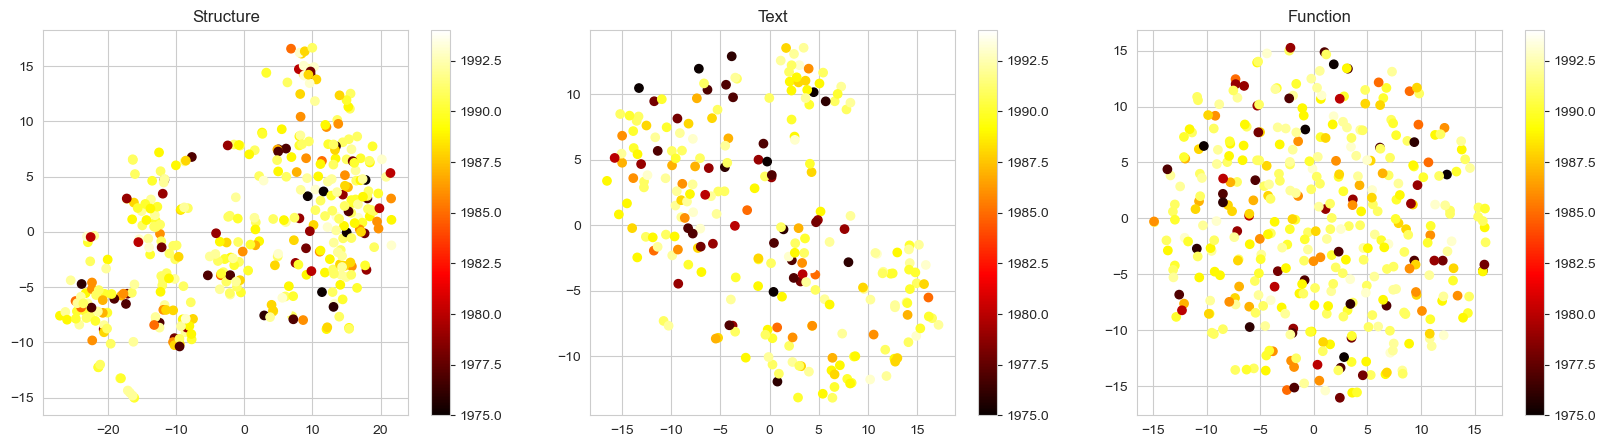

In [200]:
df_Xmerge = pd.concat([df_x1, df_x2])
#df_Xmerge = df_Xmerge[df_Xmerge['Year'] <= 1980]
print(len(df_x1), len(df_x2), len(df_Xmerge), len(df_Xmerge["Chemical"].unique()), len(df_Xmerge["Pmid"].unique()))

df_op_sm = df_Xmerge.drop_duplicates(subset=['Chemical'], keep='first')
sm_ary = np.array([list(x) for x in df_op_sm.smile_embd])

tsne_sm = TSNE(n_components=2, random_state=42, metric='cosine')
transformed_data_sm = tsne_sm.fit_transform(sm_ary)

df_op_txt = df_Xmerge.drop_duplicates(subset=['Pmid'], keep='first')
txt_ary = np.array([list(x) for x in df_op_txt.openai_embd])

tsne_txt = TSNE(n_components=2, random_state=42, metric='cosine')
transformed_data_txt = tsne_txt.fit_transform(txt_ary)

df_op_nt = df_Xmerge.drop_duplicates(subset=['Chemical'], keep='first')
nt_ary = np.array([list(x) for x in df_op_nt.ntwk_embd])
tsne_ntwk = TSNE(n_components=2, random_state=42, metric='cosine')
transformed_data_ntwk = tsne_txt.fit_transform(nt_ary)

fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title('Structure')
sc1 = ax1.scatter(transformed_data_sm[:, 0], transformed_data_sm[:, 1], c=df_op_sm.Year.astype(int), cmap='hot')
colorbar1 = fig.colorbar(sc1, ax=ax1)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title('Text')
sc2 = ax2.scatter(transformed_data_txt[:, 0], transformed_data_txt[:, 1], c=df_op_txt.Year.astype(int), cmap='hot')
colorbar2 = fig.colorbar(sc2, ax=ax2)


ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title('Function')
sc3 = ax3.scatter(transformed_data_ntwk[:, 0], transformed_data_ntwk[:, 1], c=df_op_nt.Year.astype(int), cmap='hot')
colorbar3 = fig.colorbar(sc3, ax=ax3)
plt.show()

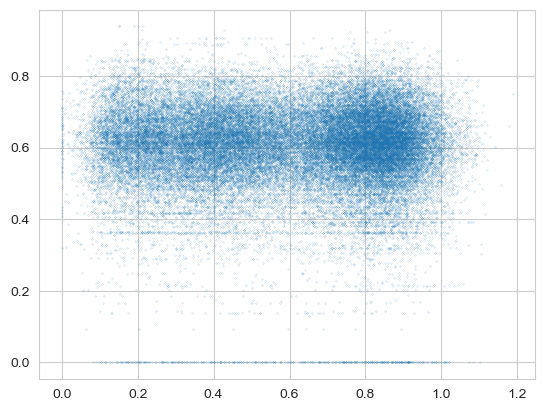

In [201]:
plt.scatter(df_distance_sample['dis_smile'], df_distance_sample['dis_openai'], s=0.01)

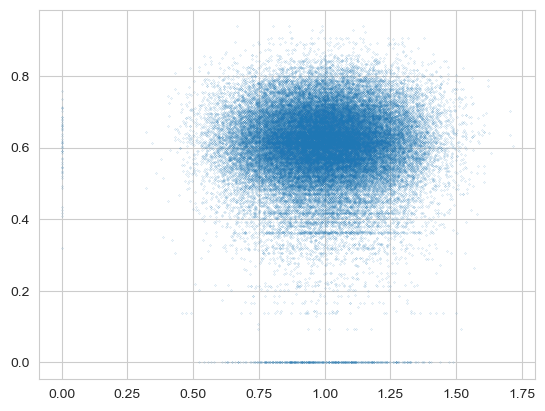

In [202]:
plt.scatter(df_distance_sample['dis_ntwk'], df_distance_sample['dis_openai'], s=0.01)

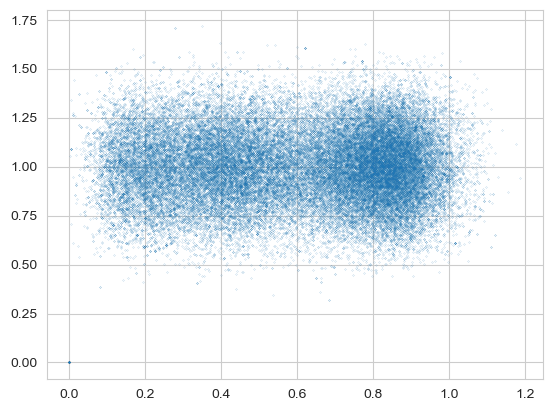

In [203]:
plt.scatter(df_distance_sample['dis_smile'], df_distance_sample['dis_ntwk'], s=0.01)

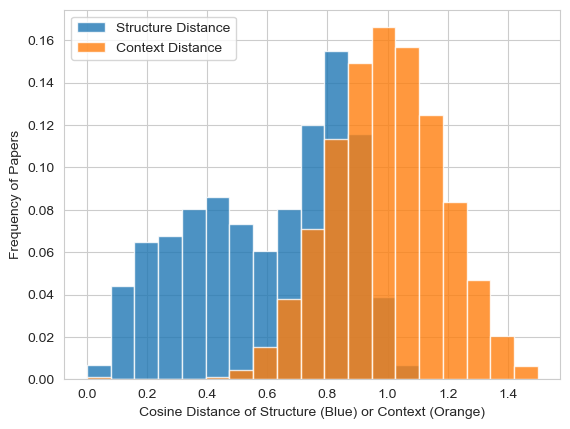

In [205]:
df_hist = df_distance_sample
plt.hist(df_hist['dis_smile'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Structure Distance', bins=np.linspace(0, 1.5, 20), alpha=0.8)
plt.hist(df_hist['dis_ntwk'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Context Distance', bins=np.linspace(0, 1.5, 20), alpha=0.8)
plt.ylabel('Frequency of Papers')
plt.xlabel('Cosine Distance of Structure (Blue) or Context (Orange)')
plt.legend(loc='upper left')
plt.show()

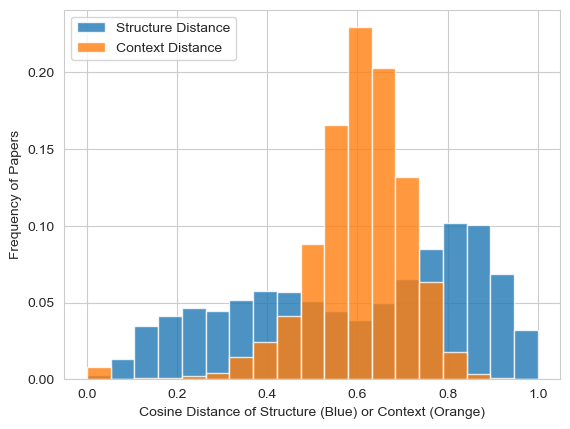

In [106]:
df_hist = df_distance_sample
plt.hist(df_hist['dis_smile'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Structure Distance', bins=np.linspace(0, 1, 20), alpha=0.8)
plt.hist(df_hist['dis_openai'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Context Distance', bins=np.linspace(0, 1, 20), alpha=0.8)
plt.ylabel('Frequency of Papers')
plt.xlabel('Cosine Distance of Structure (Blue) or Context (Orange)')
plt.legend(loc='upper left')
plt.show()

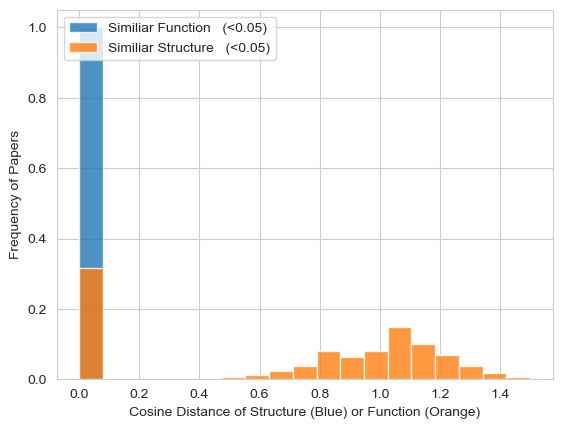

In [207]:
df_hist = df_distance_sample[df_distance_sample['dis_ntwk'] < 0.05]
plt.hist(df_hist['dis_smile'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Similiar Function   (<0.05)', bins=np.linspace(0, 1.5, 20), alpha=0.8)
df_hist = df_distance_sample[df_distance_sample['dis_smile'] < 0.05]
plt.hist(df_hist['dis_ntwk'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Similiar Structure   (<0.05)', bins=np.linspace(0, 1.5, 20), alpha=0.8)
plt.ylabel('Frequency of Papers')
plt.xlabel('Cosine Distance of Structure (Blue) or Function (Orange)')
plt.legend(loc='upper left')
plt.show()

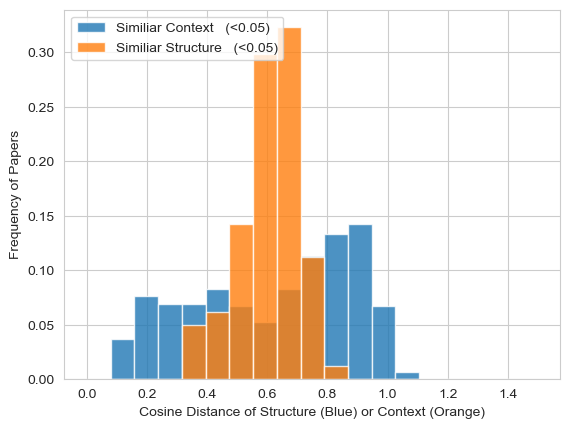

In [210]:
df_hist = df_distance_sample[df_distance_sample['dis_openai'] < 0.05]
plt.hist(df_hist['dis_smile'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Similiar Context   (<0.05)', bins=np.linspace(0, 1.5, 20), alpha=0.8)
df_hist = df_distance_sample[df_distance_sample['dis_smile'] < 0.05]
plt.hist(df_hist['dis_openai'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Similiar Structure   (<0.05)', bins=np.linspace(0, 1.5, 20), alpha=0.8)
plt.ylabel('Frequency of Papers')
plt.xlabel('Cosine Distance of Structure (Blue) or Context (Orange)')
plt.legend(loc='upper left')
plt.show()

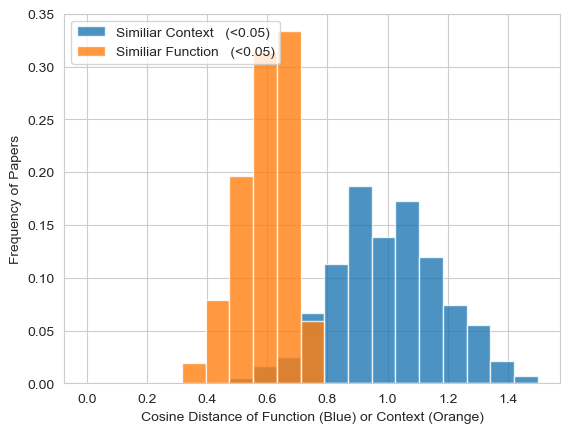

In [209]:
df_hist = df_distance_sample[df_distance_sample['dis_openai'] < 0.05]
plt.hist(df_hist['dis_ntwk'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Similiar Context   (<0.05)', bins=np.linspace(0, 1.5, 20), alpha=0.8)
df_hist = df_distance_sample[df_distance_sample['dis_ntwk'] < 0.05]
plt.hist(df_hist['dis_openai'], weights=[1 / len(df_hist)] * len(df_hist),
         label='Similiar Function   (<0.05)', bins=np.linspace(0, 1.5, 20), alpha=0.8)
plt.ylabel('Frequency of Papers')
plt.xlabel('Cosine Distance of Function (Blue) or Context (Orange)')
plt.legend(loc='upper left')
plt.show()

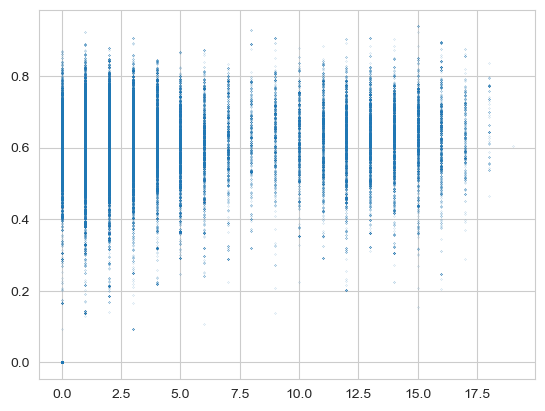

In [80]:
plt.scatter(df_distance_sample['dis_y'], df_distance_sample['dis_openai'], s=0.01)

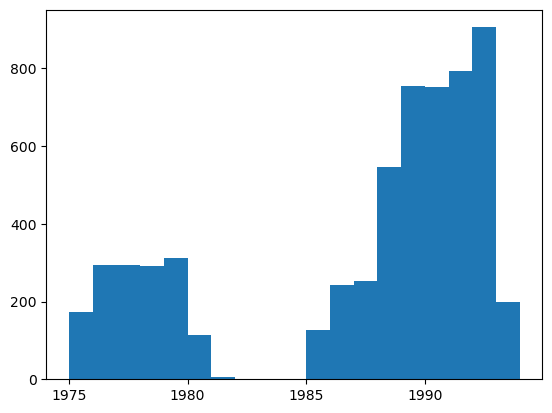

In [30]:
plt.hist(pmid_e_df.year, bins=np.arange(1975, 1995, 1))
plt.xticks(np.arange(1975, 1995, 5))
plt.show()